# Measurements

<hr>


This lecture's objectives:
- Know the basics of absorbance and optical density measurements.
- Know the basics of spectroscopy at the example of Raman spectroscopy.
- Being able to obtain concentrations from spectral data.

We are going to use a new library called [RamanSPy](https://ramanspy.readthedocs.io/en/latest/) that we will use to generate synthetic spectra. You can also check out their paper [(Georgiev, Pedersen, Xie, Fernández-Galiana, Stevens, and Barahona; Analytical Chemistry 2024)](https://pubs.acs.org/doi/full/10.1021/acs.analchem.4c00383).

In [168]:
# Uncomment the following line to install required packages

# %pip install requests ramanspy

In [169]:
import matplotlib.pyplot as plt
import numpy as np
import ramanspy as rp
import pint
import scipy

u = pint.UnitRegistry()

## Composition of a liquid culture

One often needs to determine the concentration of cells and medium components with a volume. Depending on the biological or chemical species of interest there is a variety of measurement techniques available.

We will discuss two representative methods:
- Absorbance and Optical density (OD)
- Spectroscopy; in particular Raman spectroscopy

Both these techniques rely on the sample being exposed to a light source, and collecting information about the light being modulated by the sample.

A third technique that follows the same principle, but requires different computational processing and analysis methods is microscopy - with an own upcoming lecture devoted to this topic.

## Absorbance

Let's start with the perhaps simplest method to determine the concentration of bacteria in a liquid culture.
In fact you will intuitively have used this method many times, perhaps in other contexts: simply look at it in a transparent container like a glass or flask.

This is not specific to bacteria and growth medium, but works with many suspensions (e.g., sand in water) or emulsions (e.g., milk in water): the higher the concentration of the dispersed substance, the more light is absorbed when shining light from one side and looking at it from the opposing side.

We can formulate the measurement setup as:
- A light beam (e.g., from an LED or laser) that is traversing a sample in a transparent cuvette.
- Measurement of light intensity received at the other side (e.g., by a photo diode) and comparison to the intensity received in presence of no sample.
- We expect the received light intensity to decrease with the concentration.

There are some limitations to this, though:
- When done in the lab for bacteria grown in, say LB medium, you may see by eye that the liquid becomes turbid, but this is not very precise. In more generality, it works better with something intransparent like sand than with something transparent like _E. coli_ bacteria.
- It becomes darker, but there is also a color change that gives us more information that the pure absorbance: sandy water becomes brown and milky water white. If you see a white solution you would expect it contains more milk than sand; and the other way for a brown solution.
- It does not work for all dissolved substances. For example, we do not observe this with solutions like salty water, unless we add a lot of salt.


## Optical Density

## Raman spectroscopy

The following figure shows a representative Raman spectroscopy setup.

![Raman spectroscopy setup schematic](https://upload.wikimedia.org/wikipedia/commons/d/db/Setup_Raman_Spectroscopy_adapted_from_Thomas_Schmid_and_Petra_Dariz_in_Heritage_2%282%29_%282019%29_1662-1683.png)

**Figure:** Schematic of a Raman spectroscopy setup. Adapted from Thomas Schmid and Petra Dariz (2019). "Raman Microspectroscopic Imaging of Binder Remnants in Historical Mortars Reveals Processing Conditions". *Heritage* 2(2): 1662–1683. Image by Toommm, [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/), via [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Setup_Raman_Spectroscopy_adapted_from_Thomas_Schmid_and_Petra_Dariz_in_Heritage_2(2)_(2019)_1662-1683.png).

In the setup, photons from the laser beam are projected onto a sample.
Two types of photons are observed after hitting the sample.
1. Most photons are elastically scattered by the material without (or with almost no, as in an elastic collision with a huge mass) energy change. Only the direction changes due to the collision.
2. Some photons, however, are observed to have a different energy level and thus a different frequency. This is due to vibrational changes within the material, resp., its chemical bonds, induced by the collision.

The second type of photons are those that contain the information we are interested in. They are collected and their counts and wavenumber ($\text{cm}^{-1}$) are reported. In fact the difference in the wavenumber of the received photon and the emmited photon is reported; resulting in a Raman spectrum. This difference is called the Raman shift ($\text{cm}^{-1}$).

### Wavenumber notation

In Raman spectroscopy, one commonly uses wavenumber rather than wavelength or frequency to characterize photons. This choice is not arbitrary - wavenumber offers practical advantages for spectroscopic measurements.

The wavenumber $\tilde\nu$ [$\text{m}^{-1}$] is related to the wavelength $\lambda$ [$\text{m}$] via

$$\tilde\nu = \frac{1}{\lambda}$$

From the relation between frequnecy $\nu$ [$\text{s}^{-1}$] and the speed of a photon $c$ [$ms^{-1}$], we have

$$\tilde\nu = \frac{\nu}{c}$$

The wavenumber is convenient because it is directly proportional to both the frequency and the energy of a photon via the [Planck relation](https://en.wikipedia.org/wiki/Planck_relation):

$$E = h\nu = hc\tilde\nu$$

This direct proportionality means that when we look at a Raman spectrum plotted against wavenumber, peaks at higher wavenumbers correspond to higher energy vibrational transitions in the molecular bonds. Additionally, wavenumber differences (Raman shifts) directly correspond to the energy differences of molecular vibrations, making it easier to identify and compare chemical signatures.

### A first synthetic spectrum

We will use the Python library [RamanSPy](https://ramanspy.readthedocs.io/en/latest/#) to generate a first synthetic spectrum. It shows peaks of intensity at certain wavelengths, that partially overlap creating this charactersitic spectrum. The generated spectrum does not have a backround signal. We will discuss this later in the lecture, but neglect it for the moment, asssuming that it has already been removed.

> _*Side note:*_ While we will Raman spectra, much of what follows is not specific to Raman spectroscopy and holds as well for other spectra.

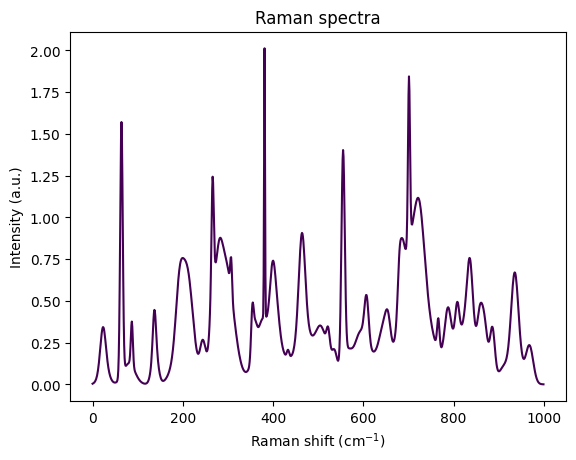

In [170]:
# Generate synthetic spectrum
spectra = rp.synth.generate_spectra(num_spectra=1, n_bands=1000, realistic=True, seed=10)

rp.plot.spectra(spectra)
rp.plot.show()

To analyse such a spectrum, we start with a simplifed notion fo a spectrum as a sum of Gaussian functions, each of which correspondis to an idealized peak of amplitude $1$.
Letting $x$ be the Raman shift, a Guassian peak is a spectrum of the form

$$
f(x) = a \cdot e^{-(x-\mu)/(2 w^2)}
$$

and we refer to $a$ as the amplitude, $\mu$ the mean, and $w$ the width.
Let's code a function that creates a peak. For simplicity we will assume here that our spectra all are between 0 and 1000 $\text{cm}^{-1}$ and comprise of 1000 bins, i.e., the numerical resolution is $1 \text{cm}^{-1}$.

In [171]:
def peak(pos: float, width: float) -> np.ndarray:
    # For simplicity we set spectral range and sample number
    # to constants.
    x = np.linspace(0,100, 1000)

    # Gauss function, with amplitude 1.
    return 1 * np.exp( -(x - pos)**2 / (2*width**2) )

We can now create a simplified first spectrum comprising peaks at 50 and 75 of widths 1 and 3, respectively.

Text(0, 0.5, 'Intensity')

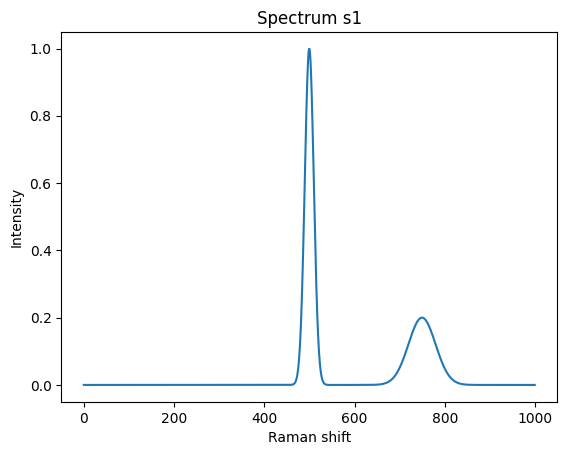

In [172]:
# Simple spectrum
s1 = peak(50,1) + 1/5*peak(75,3)

plt.figure()
plt.plot(s1)
plt.title("Spectrum s1")
plt.xlabel("Raman shift")
plt.ylabel("Intensity")

Let's create a second

Text(0, 0.5, 'Intensity')

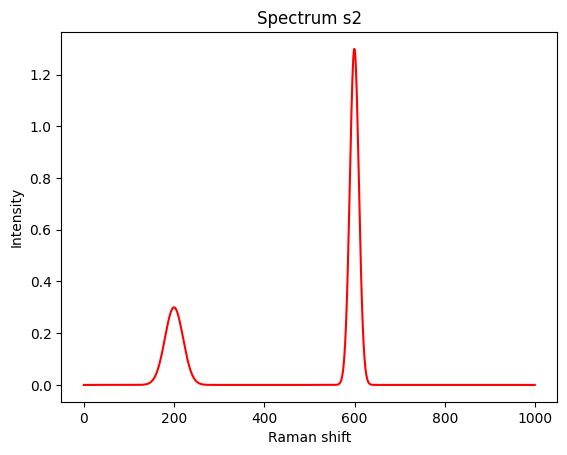

In [173]:
# Another simple spectrum
s2 = 0.3*peak(20,2) + 1.3*peak(60,1)

plt.figure()
plt.plot(s2, 'r')
plt.title("Spectrum s2")
plt.xlabel("Raman shift")
plt.ylabel("Intensity")

It's time to overlay both into a single spectrum. We assume the (bio-)chemical species responsible for spectrum $s_1$ is available in concentration $c_1 = 0.2$ and the species for $s_2$ in $c_2 = 0.5$.

In [174]:
def mix(spec: list[np.ndarray], coefficients: list[float]) -> np.ndarray:
    ret = None
    for i, s in enumerate(spec):
        ret = coefficients[i] * s + (0 if ret is None else ret)
    if ret is None:
        raise ValueError("expecting at least 1 spectrum")
    return ret

Resulting in the following spectrum (in black). The two original spectra are shown in blue and red.

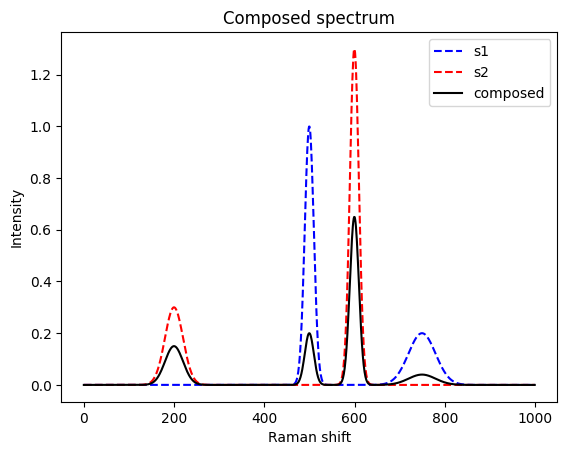

In [175]:
mixed = mix([s1, s2], [0.2, 0.5])

plt.figure()
plt.plot(s1, 'b--', label='s1')
plt.plot(s2, 'r--', label='s2')
plt.plot(mixed, 'k', label='composed')
plt.title("Composed spectrum")
plt.xlabel("Raman shift")
plt.ylabel("Intensity")
plt.legend()

The problem we would like to solve is finding the two coefficients $c_1$ and $c_2$ back from the mixed spectrum, assuming that we know it is a mix of $s_1$ and $s_2$.
We can phrase the problem as solving the least square problem

$$
\min_c \|Sc - m\|_2
$$

where

$$
S = \begin{bmatrix}
{\vec s_{1}} & \vec s_{2} \\
\end{bmatrix}
$$


$$
c = \begin{bmatrix}
c_{1}\\
c_{n}
\end{bmatrix}
$$

and $m$ is the mexied spectrum. 

In [176]:
def demix(components: list[np.ndarray], mixed: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    S = np.vstack(components).T
    c, residuals, _, _ = np.linalg.lstsq(a=S, b=mixed, rcond=None)
    return c, residuals

c, residuals = demix(components=[s1, s2], mixed=mixed)
print(f"The coefficients are {c} and the sums of squared residuals is {residuals}.")

The coefficients are [0.2 0.5] and the sums of squared residuals is [3.816829e-30].


So, indeed, we sucessfully found back the two concentrations.

## More involved spectra

The above example was well behaved with respect to several properties:
1. All peaks are well seperated and do not overlap. Neither between spectra, nor within a spectrum.
2. We knew exactly which species are present.
3. A perfectly clean spectrum was assumed: no background signal and no measurment noise is assumed.

We start by elevating (1) and (2). The next mixed spectrum has more involved spectra with overlapping peaks between and within a spectrum. Further, we are not sure if two other candidate species are present. 

The coefficients are [ 2.00000000e-01  5.00000000e-01 -4.28245569e-17 -9.07151373e-17] and the sums of squared residuals is [2.00698394e-30].


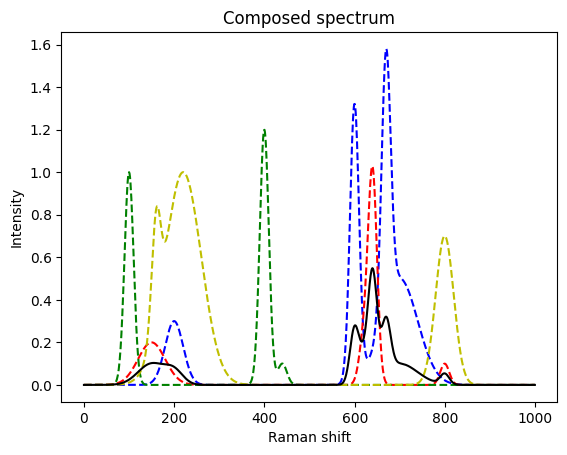

In [177]:
s3 = 0.3*peak(20,2) + 1.3*peak(60,1) + 1.2*peak(67,1) + 0.5*peak(70,4)
s4 = 0.2*peak(15,3) + 0.2*peak(62,1) + 1.0*peak(64,1) + 0.1*peak(80,1)
s5 = 1.0*peak(10,1) + 1.2*peak(40,1) + 0.1*peak(44,1)
s6 = 0.5*peak(16,1) + 1.0*peak(22,4) + 0.7*peak(80,2)
mixed = mix([s3, s4, s5, s6], [0.2, 0.5, 0.0, 0.0])

plt.figure()
plt.plot(s3, 'b--')
plt.plot(s4, 'r--')
plt.plot(s5, 'g--')
plt.plot(s6, 'y--')
plt.plot(mixed, 'k')
plt.title("Composed spectrum")
plt.xlabel("Raman shift")
plt.ylabel("Intensity")

c, residuals = demix(components=[s3, s4, s5, s6], mixed=mixed)
print(f"The coefficients are {c} and the sums of squared residuals is {residuals}.")

Again, we found back the initial concentrations.

In [178]:
def make_noisy(spec: list[np.ndarray], factor=0.1) -> list[np.ndarray]:
    ret = []
    for s in spec:
        gaussian_multiplicative_noise = np.random.normal(loc=1.0, scale=factor, size=spec[0].shape)
        ret.append(s * gaussian_multiplicative_noise)
    return ret

The coefficients are [ 2.03043721e-01  4.78771439e-01  5.85396227e-05 -1.27394654e-04] and the sums of squared residuals is [0.20819475].


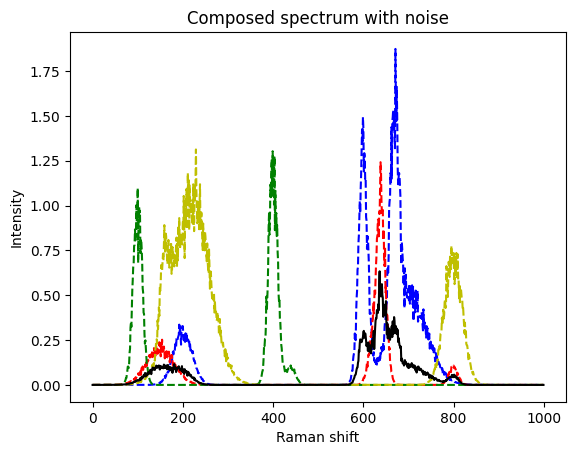

In [179]:
s3 = 0.3*peak(20,2) + 1.3*peak(60,1) + 1.2*peak(67,1) + 0.5*peak(70,4)
s4 = 0.2*peak(15,3) + 0.2*peak(62,1) + 1.0*peak(64,1) + 0.1*peak(80,1)
s5 = 1.0*peak(10,1) + 1.2*peak(40,1) + 0.1*peak(44,1)
s6 = 0.5*peak(16,1) + 1.0*peak(22,4) + 0.7*peak(80,2)

# make noisy
s3_noisy, s4_noisy, s5_noisy, s6_noisy = make_noisy([s3, s4, s5, s6])

# use the real / not noisy compounds to create the spectrum
mixed = mix([s3, s4, s5, s6], [0.2, 0.5, 0.0, 0.0])
# and make it noisy
mixed_noisy = make_noisy([mixed])[0]

plt.figure()
plt.plot(s3_noisy, 'b--')
plt.plot(s4_noisy, 'r--')
plt.plot(s5_noisy, 'g--')
plt.plot(s6_noisy, 'y--')
plt.plot(mixed_noisy, 'k')
plt.title("Composed spectrum with noise")
plt.xlabel("Raman shift")
plt.ylabel("Intensity")

c, residuals = demix(components=[s3_noisy, s4_noisy, s5_noisy, s6_noisy], mixed=mixed_noisy)
print(f"The coefficients are {c} and the sums of squared residuals is {residuals}.")

Still a very good match of coefficients.

## Bacterial spectra

Following the tutorial on [RamanSPy](https://ramanspy.readthedocs.io/en/latest/datasets.html#bacteria-data) we next download a dataset of bacterial spectra obtained by [Ho et al. (Nat Commun, 2019)](https://www.nature.com/articles/s41467-019-12898-9). Following the [RamanSPy - loading bacterial data](https://ramanspy.readthedocs.io/en/latest/auto_tutorials/iii-datasets/plot_i_bacteria.html#sphx-glr-auto-tutorials-iii-datasets-plot-i-bacteria-py) tutorial, we get:

In [180]:
# change this to the downloaded data dir
data_dir = "data"

# get the training data
X_train, y_train = rp.datasets.bacteria("val", folder=data_dir)
y_labels, _ = rp.datasets.bacteria("labels")

spectra = [[X_train[y_train == species_id]] for species_id in list(np.unique(y_train))]
spectra_norm = rp.preprocessing.normalise.MinMax().apply(spectra)

# plot all spectra
plt.figure(figsize=(6.5, 9))
rp.plot.mean_spectra(spectra_norm, label=y_labels, plot_type="single stacked", title="bacterial spectra");

plt.figure()
idx_ecoli = 3
rp.plot.mean_spectra(spectra_norm[idx_ecoli], label=y_labels[idx_ecoli], plot_type="single stacked", title="bacterial spectra");
spectra_norm[idx_ecoli]

FileNotFoundError: [Errno 2] No such file or directory: 'data/X_finetune.npy'

In [ ]:
# the two components
plt.figure()
ecoli_spectrum = spectra[idx_ecoli][0][0]
rp.plot.spectra(ecoli_spectrum)
plt.title("E. coli spectrum")

plt.figure()
calbicans_spectrum = spectra[0][0][0]
rp.plot.spectra(calbicans_spectrum)
plt.title("C. albicans spectrum")

# creating a mixed one
to_mix = [ecoli_spectrum, calbicans_spectrum]
cs = np.array([0.2, 0.5])
mixed_bac = rp.synth.mix(to_mix, cs, mixture_mode='linear', noise=False, baseline=False, seed=42)

plt.figure()
rp.plot.spectra(mixed_bac)
plt.title("Mixed bacterial spectrum")

NameError: name 'idx_ecoli' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
c, redidual = demix(components=[ecoli_spectrum.spectral_data, calbicans_spectrum.spectral_data], mixed=mixed_bac.spectral_data)
print(f"The coefficients are {c} and the sums of squared residuals is {residuals}.")

The coefficients are [0.2 0.5] and the sums of squared residuals is [0.20819475].


## Removing noise and a background signal

- May exist, e.g., because of a fluorescent background.
- Assume the spectrum of the background is not known and can not be simply subtracted.
- Estimate the baseline and subtract it. Also called baseline correction.

Let's create a synthetic spectrum with a simple backgorund and noise.

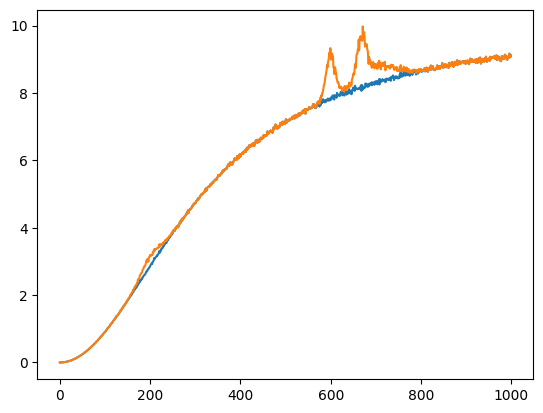

In [ ]:
x = np.linspace(0,100, 1000)

# make a noisy background
background_signal = make_noisy(
    [x**2 / (1 + x**2/1000) * 1/100],
    factor=0.005
)
plt.plot(background_signal[0])

# and add it to our signal
s3_nosiy_bck = background_signal[0] + s3_noisy
plt.plot(s3_nosiy_bck)

Same for the other signals.

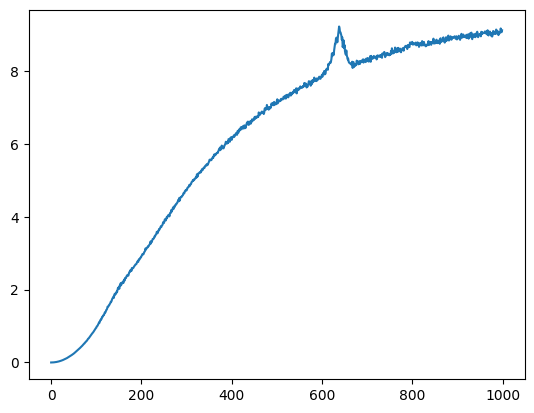

In [ ]:
s4_nosiy_bck = background_signal[0] + s4_noisy
plt.plot(s4_nosiy_bck)

### Removing noise: Savitzky–Golay filter

Given a signal, one can locally, i.e., within a symmetric window of a fixed size around the point to be approximated, fit a least-square error polynomial. The simplest such filter is a non-causal moving average. The filter is a least-squares solution to fitting a polynomial of degree 0.

Further literature
- Reading and discussing [Savitzky–Golay filters](https://en.wikipedia.org/wiki/Savitzky–Golay_filter) as a way to locally fit a polinomial to the signal, or equivalently, perform a convolution with a non-causal filter signal.
- The paper [Savitzky and Golay (1964)](https://pubs.acs.org/doi/abs/10.1021/ac60214a047).

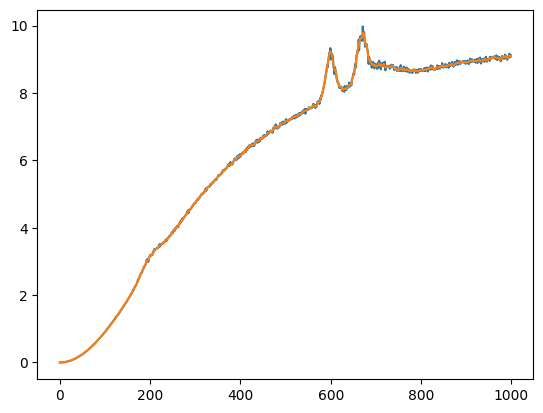

In [ ]:
s3_denoise_est = scipy.signal.savgol_filter(x=s3_nosiy_bck, window_length=9, polyorder=3)

plt.figure()
plt.plot(s3_nosiy_bck)
plt.plot(s3_denoise_est)

### Removing the background

Text(0.5, 1.0, 'Estimated signal and signal')

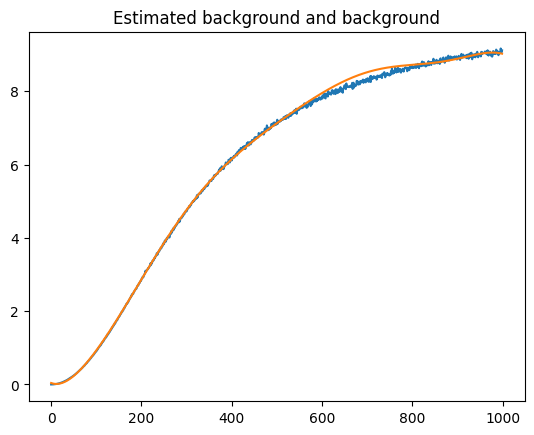

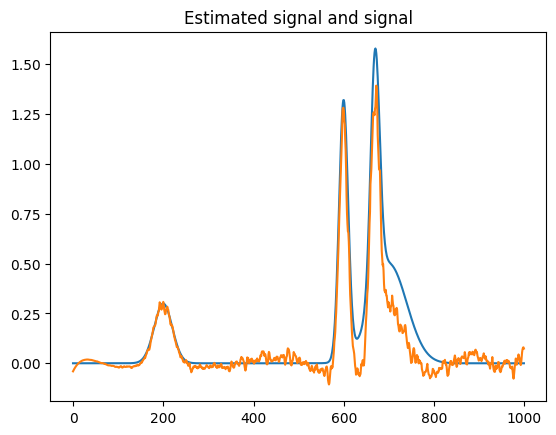

In [ ]:
# setup the preprocessing pipeline
pipe = rp.preprocessing.protocols.Pipeline([
    # rp.preprocessing.denoise.SavGol(window_length=9, polyorder=3),
    rp.preprocessing.baseline.IModPoly(poly_order=10),
])

# apply pipeline
s3_est = pipe.apply(rp.Spectrum(s3_denoise_est, x))

# backgorund estimate
bkg_est = s3_denoise_est - s3_est.spectral_data

# plot the results
# _ = rp.plot.spectra(s3_est, plot_type='separate')

plt.figure()
plt.plot(background_signal[0])
plt.plot(bkg_est)
plt.title("Estimated background and background")

plt.figure()
plt.plot(s3)
plt.plot(s3_est.spectral_data)
plt.title("Estimated signal and signal")

More information on background removal in signals can be found at the page of the Python package [pybaselines](https://pybaselines.readthedocs.io/en/latest/index.html). For example, you can checkout this [example](https://pybaselines.readthedocs.io/en/latest/examples/general/plot_noisy_data.html#sphx-glr-examples-general-plot-noisy-data-py) as a start.

## Application: Determining the growth state of a bacterium

Reading and discussing the paper by [Ren et al. (2017)](https://microbialcellfactories.biomedcentral.com/articles/10.1186/s12934-017-0849-8).

## Application: Tracking the kinetics in a bioreactor

Reading and discussing the paper by [Lee et al. (2004)](https://web.mit.edu/biology/sinskey/www/HarryLee04.pdf) and the overview paper by [Lourenço et al. (2012)](https://link.springer.com/article/10.1007/s00216-012-6073-9).

## Optical density and Spectrophotometry

### Quick overview on how it works

- Either white light, or a light of a particular wavelength is used as a source.
- The light is both adsorbed and scattered by the material in the medium and the medium. The effect of the medium is tried to counteract with choosing a wevelength that shows low absorption and removing the measurement of the medium from the final outcome ("blanking").
- Typically the light scattering effect is larger than the absorption effect. This means that shape and surface properties of the particles in the medium have an influence on the readout.
- Scattered photons are blocked by letting only photons that are scattered in a certain angel hit a digital sensor.


## Application: Tracking the cell density in a microplate reader

On the blackboard


Further literature:
- Read and discuss the work by [Hu et al. (2023)](https://onlinelibrary.wiley.com/doi/full/10.1155/2023/3611665).

## Flow cytometry

Schematic shown within this [wikimedia image](https://en.wikipedia.org/wiki/Flow_cytometry#/media/File:Cytometer.svg).

- Same as before, but with single cells sequentially being measured in (flowing) medium.
- Laser as source.
- Measuring forward scatter (FS/FSC) and sideward scatter (SS/SSC) as intensity of the captured pulse. The FS is mostly a function of particle size, and the SS of the granularity/complexity of the structure.
- Possibility to differentiate received light by wavelength.
- Each cell results in a single measurement of FS and SS intensities (the latter, potentially separated for different wavelengths).

---
**License**: © 2025 Matthias Függer and Thomas Nowak. Licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).